# Importing Required Packages 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import string
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report

# Converting To Dataframe

In [8]:
import os
# Step 1 - Get the file details
directory = []
file = []
title = []
text = []
label = []
datapath = 'E:/Data_science/document_classification/bbc/bbc-fulltext (document classification)/bbc/' 
for dirname, _ , filenames in os.walk(datapath):
    #print('Directory: ', dirname)
    #print('Subdir: ', dirname.split('/')[-1])
    # remove the Readme.txt file
    # will not find file in the second iteration so we skip the error
    try:
        filenames.remove('README.TXT')
    except:
        pass
    for filename in filenames:
        directory.append(dirname)
        file.append(filename)
        label.append(dirname.split('/')[-1])
        #print(filename)
        fullpathfile = os.path.join(dirname,filename)
        with open(fullpathfile, 'r', encoding="utf8", errors='ignore') as infile:
            intext = ''
            firstline = True
            for line in infile:
                if firstline:
                    title.append(line.replace('\n',''))
                    firstline = False
                else:
                    intext = intext + ' ' + line.replace('\n','')
            text.append(intext)

In [9]:
fulldf = pd.DataFrame(list(zip(directory, file, title, text, label)), 
               columns =['directory', 'file', 'title', 'text', 'label'])

df = fulldf.filter(['title','text','label'], axis=1)

print("FullDf : ", fulldf.shape)
print("DF : ", df.shape)

FullDf :  (2225, 5)
DF :  (2225, 3)


In [10]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2)
print("Train DF: ",train.shape)
print("Test DF: ",test.shape)

Train DF:  (1780, 3)
Test DF:  (445, 3)


In [12]:
train

,title,text,label
2171,Game makers get Xbox 2 sneak peek,Microsoft has given game makers a glimpse of...,tech
545,Hanks greeted at wintry premiere,Hollywood star Tom Hanks was in London's Lei...,entertainment
932,Profile: David Miliband,David Miliband's rapid rise through the rank...,politics
54,SA unveils 'more for all' budget,The South African government has put tax cut...,business
1724,Dominici backs lacklustre France,Wing Christophe Dominici says France can cla...,sport
...,...,...,...
1012,Boothroyd calls for Lords speaker,Betty Boothroyd has said the House of Lords ...,politics
1476,Ajax refuse to rule out Jol move,Ajax have refused to reveal whether Tottenha...,sport
1453,Benitez issues warning to Gerrard,Liverpool manager Rafael Benitez has ordered...,sport
986,Vouchers 'to cut winter deaths',Pensioners are being promised energy savings...,politics


In [13]:
text_df = train[['label', 'text']]
text_df.head()

,label,text
2171,tech,Microsoft has given game makers a glimpse of...
545,entertainment,Hollywood star Tom Hanks was in London's Lei...
932,politics,David Miliband's rapid rise through the rank...
54,business,The South African government has put tax cut...
1724,sport,Wing Christophe Dominici says France can cla...


In [14]:
text_df.shape

(1780, 2)

In [15]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1780 entries, 2171 to 706
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   1780 non-null   object
 1   text    1780 non-null   object
dtypes: object(2)
memory usage: 41.7+ KB


In [17]:
text_df.isnull().sum()

label    0
text     0
dtype: int64

In [18]:
text_df['text'][2]

'  The owners of embattled Russian oil giant Yukos are to ask the buyer of its former production unit to pay back a $900m (£479m) loan.  State-owned Rosneft bought the Yugansk unit for $9.3bn in a sale forced by Russia to part settle a $27.5bn tax claim against Yukos. Yukos\' owner Menatep Group says it will ask Rosneft to repay a loan that Yugansk had secured on its assets. Rosneft already faces a similar $540m repayment demand from foreign banks. Legal experts said Rosneft\'s purchase of Yugansk would include such obligations. "The pledged assets are with Rosneft, so it will have to pay real money to the creditors to avoid seizure of Yugansk assets," said Moscow-based US lawyer Jamie Firestone, who is not connected to the case. Menatep Group\'s managing director Tim Osborne told the Reuters news agency: "If they default, we will fight them where the rule of law exists under the international arbitration clauses of the credit."  Rosneft officials were unavailable for comment. But the 

In [19]:
text_df['text']=text_df['text'].astype(str)

C:\Users\sudharsan.s\Anaconda3\envs\Doc_class\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [20]:
# Total number of words in the data
print(text_df['text'].apply(lambda x: len(x.split(' '))).sum())

688509


In [21]:
text_df.dropna(subset=['text'], inplace=True)

C:\Users\sudharsan.s\Anaconda3\envs\Doc_class\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [22]:
text_df.isnull().sum()

label    0
text     0
dtype: int64

In [23]:
text_df['length'] = text_df['text'].apply(len)
text_df.head()

,label,text,length
2171,tech,Microsoft has given game makers a glimpse of...,2556
545,entertainment,Hollywood star Tom Hanks was in London's Lei...,1320
932,politics,David Miliband's rapid rise through the rank...,1266
54,business,The South African government has put tax cut...,2018
1724,sport,Wing Christophe Dominici says France can cla...,1802


In [24]:
text_df.label.unique()

array(['tech', 'entertainment', 'politics', 'business', 'sport'],
      dtype=object)

In [25]:
text_df.label.value_counts()

sport            416
business         400
politics         338
tech             316
entertainment    310
Name: label, dtype: int64

In [28]:
test

,title,text,label
1538,Wolves appoint Hoddle as manager,Glenn Hoddle will be unveiled as the new Wol...,sport
1037,EU referendum question unveiled,The question to be asked in the referendum o...,politics
1123,Labour pig poster 'anti-Semitic',The Labour Party has been accused of anti-Se...,politics
735,Fox 'too reliant on reality TV',The head of US TV network Fox has admitted t...,entertainment
1997,Gadgets galore on show at fair,The 2005 Consumer Electronics Show in Las Ve...,tech
...,...,...,...
146,Malaysia lifts Islamic bank limit,Malaysia's central bank is to relax restrict...,business
246,Renault boss hails 'great year',Strong sales outside western Europe helped R...,business
1025,Blair told to double overseas aid,Tony Blair is being urged to use all his neg...,politics
1696,Borders 19-20 Ulster,Ulster clung on for a morale-boosting Celtic...,sport


In [72]:
textdf.label.value_counts()

business         110
sport             95
tech              85
politics          79
entertainment     76
Name: label, dtype: int64

In [29]:
textdf = test[['label', 'text']]
textdf.head()

,label,text
1538,sport,Glenn Hoddle will be unveiled as the new Wol...
1037,politics,The question to be asked in the referendum o...
1123,politics,The Labour Party has been accused of anti-Se...
735,entertainment,The head of US TV network Fox has admitted t...
1997,tech,The 2005 Consumer Electronics Show in Las Ve...


In [30]:
textdf['text']=textdf['text'].astype(str)

C:\Users\sudharsan.s\Anaconda3\envs\Doc_class\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [31]:
textdf.dropna(subset=['text'], inplace=True)

C:\Users\sudharsan.s\Anaconda3\envs\Doc_class\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [32]:
textdf['length'] = textdf['text'].apply(len)
textdf.head()

,label,text,length
1538,sport,Glenn Hoddle will be unveiled as the new Wol...,1365
1037,politics,The question to be asked in the referendum o...,3181
1123,politics,The Labour Party has been accused of anti-Se...,1747
735,entertainment,The head of US TV network Fox has admitted t...,1614
1997,tech,The 2005 Consumer Electronics Show in Las Ve...,5066


# Vizualization

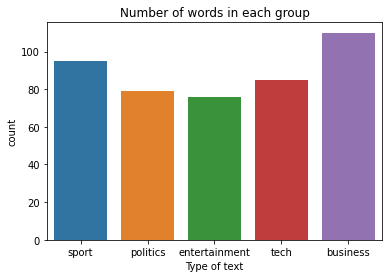

In [73]:
sns.countplot(x='label',data=textdf, saturation=0.75)
plt.xlabel('Type of text')
plt.title('Number of words in each group');

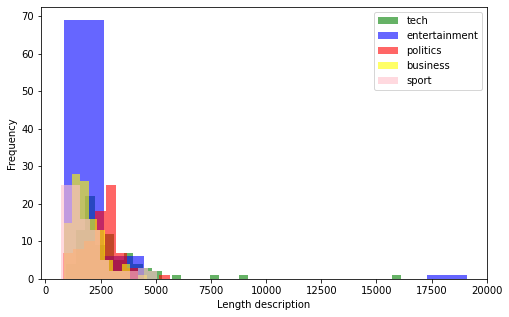

In [36]:
plt.figure(figsize=(8, 5))
textdf[textdf.label == 'tech'].length.plot(bins=35, kind='hist', color='green', label='tech', alpha=0.6)
textdf[textdf.label == 'entertainment'].length.plot(kind='hist', color='blue', label='entertainment', alpha=0.6)
textdf[textdf.label == 'politics'].length.plot(kind='hist', color='red', label='politics', alpha=0.6)
textdf[textdf.label == 'business'].length.plot(kind='hist', color='yellow', label='business', alpha=0.6)
textdf[textdf.label == 'sport'].length.plot(kind='hist', color='pink', label='sport', alpha=0.6)
plt.legend()
plt.xlabel("Length description");

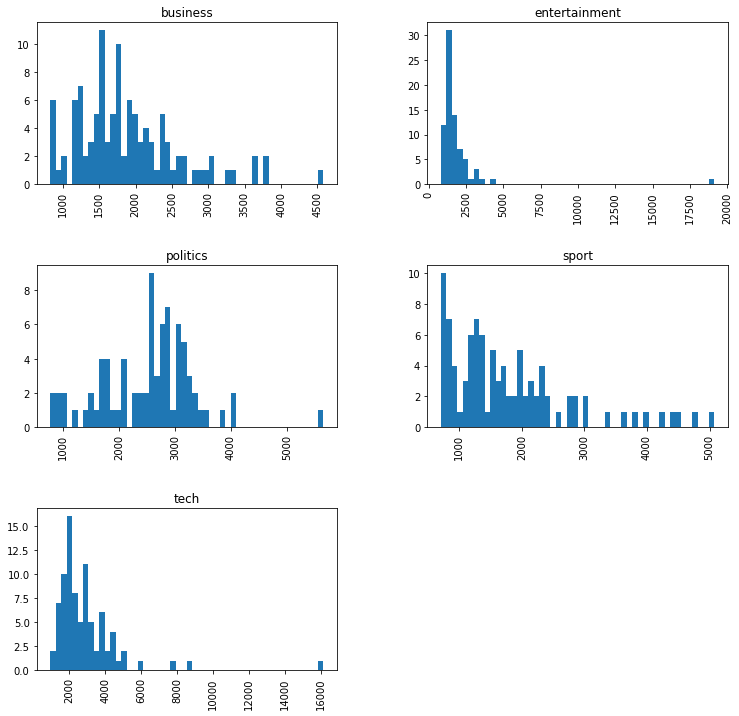

In [37]:
textdf.hist(column='length', by='label', bins=50,figsize=(12,12));

# Text pre-processing

In [38]:
stop = stopwords.words('english')
print(stop[::10])

porter = PorterStemmer()

['i', "you've", 'himself', 'they', 'that', 'been', 'a', 'while', 'through', 'in', 'here', 'few', 'own', 'just', 're', 'doesn', 'ma', "shouldn't"]


In [39]:
def remove_punctuation(description):
    """The function to remove punctuation"""
    table = str.maketrans('', '', string.punctuation)
    return description.translate(table)

def remove_stopwords(text):
    """The function to removing stopwords"""
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)

def stemmer(stem_text):
    """The function to apply stemming"""
    stem_text = [porter.stem(word) for word in stem_text.split()]
    return " ".join(stem_text)

In [40]:
textdf['text'] = textdf['text'].apply(remove_punctuation)
textdf['text'] = textdf['text'].apply(remove_stopwords)
textdf['text'] = textdf['text'].apply(stemmer)

In [46]:
textdf.head()

,label,text,length
1538,sport,glenn hoddl unveil new wolv manag tuesday club...,1365
1037,politics,question ask referendum eu constitut unveil go...,3181
1123,politics,labour parti accus antisemit poster depict mic...,1747
735,entertainment,head us tv network fox admit broadcast reli he...,1614
1997,tech,2005 consum electron show la vega geek paradis...,5066


# POS Tagging


To get the deeper insight to the way in which that word is used in speech, the Part of speech (POS) 
tagging method has been used. There are eight primary parts of speech and they each have a corresponding 
tag. The NLTK libary has a method to perform POS tagging.

In [54]:
import nltk
tokens = text_df['text'][3]
nltk.pos_tag(word_tokenize(tokens))

[('British', 'JJ'),
 ('Airways', 'NNP'),
 ('has', 'VBZ'),
 ('blamed', 'VBN'),
 ('high', 'JJ'),
 ('fuel', 'NN'),
 ('prices', 'NNS'),
 ('for', 'IN'),
 ('a', 'DT'),
 ('40', 'CD'),
 ('%', 'NN'),
 ('drop', 'NN'),
 ('in', 'IN'),
 ('profits', 'NNS'),
 ('.', '.'),
 ('Reporting', 'VBG'),
 ('its', 'PRP$'),
 ('results', 'NNS'),
 ('for', 'IN'),
 ('the', 'DT'),
 ('three', 'CD'),
 ('months', 'NNS'),
 ('to', 'TO'),
 ('31', 'CD'),
 ('December', 'NNP'),
 ('2004', 'CD'),
 (',', ','),
 ('the', 'DT'),
 ('airline', 'NN'),
 ('made', 'VBD'),
 ('a', 'DT'),
 ('pre-tax', 'JJ'),
 ('profit', 'NN'),
 ('of', 'IN'),
 ('£75m', 'NNP'),
 ('(', '('),
 ('$', '$'),
 ('141m', 'CD'),
 (')', ')'),
 ('compared', 'VBN'),
 ('with', 'IN'),
 ('£125m', 'NN'),
 ('a', 'DT'),
 ('year', 'NN'),
 ('earlier', 'RBR'),
 ('.', '.'),
 ('Rod', 'NNP'),
 ('Eddington', 'NNP'),
 (',', ','),
 ('BA', 'NNP'),
 ("'s", 'POS'),
 ('chief', 'JJ'),
 ('executive', 'NN'),
 (',', ','),
 ('said', 'VBD'),
 ('the', 'DT'),
 ('results', 'NNS'),
 ('were', 'VBD'),


# Bag of words

To run machine learning algorithms we need to convert the text files into numerical feature vectors. 
We will use bag of words model for our analysis. In general we segment each text file into words and 
count of times each word occurs in each document and finally assign each word an integer id. Each unique 
word in our dictionary will correspond to a feature (descriptive feature). More precisely we will convert 
our text documents to a matrix of token counts (CountVectorizer), then transform a count matrix to a 
normalized tf-idf representation (tf-idf transformer).

In [55]:
vectorizer = CountVectorizer()
vectorizer.fit(text_df['text'])
vector = vectorizer.transform(text_df['text'])

In [56]:
print(vector.shape)
print(vector.toarray())

(1780, 26924)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [57]:
tfidf_converter = TfidfTransformer()
X_tfidf = tfidf_converter.fit_transform(vector).toarray()
X_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [58]:
X = text_df['text']
y = text_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)

In [59]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1335,), (445,), (1335,), (445,))

# Models

We used the Multi-Classification models.

The classification models evaluated are:

1.Logistic Regression,
2.Linear Support Vector Machine,
3.Multinomial Naive Bayes.
4.Random Forest
5.Gradient Boosting

In [60]:
model_log = Pipeline([('vect', CountVectorizer(min_df=5, ngram_range=(1,2))),
                      ('tfidf', TfidfTransformer()),
                      ('model',LogisticRegression()),
                     ])

model_log.fit(X_train, y_train)

ytest = np.array(y_test)
pred = model_log.predict(X_test)

In [61]:
print('accuracy %s' % accuracy_score(pred, y_test))
print(classification_report(ytest, pred))

accuracy 0.9685393258426966
               precision    recall  f1-score   support

     business       0.92      0.98      0.95       101
entertainment       1.00      0.94      0.97        72
     politics       0.98      0.94      0.96        90
        sport       0.99      0.99      0.99       102
         tech       0.97      0.97      0.97        80

     accuracy                           0.97       445
    macro avg       0.97      0.97      0.97       445
 weighted avg       0.97      0.97      0.97       445



In [62]:
svc = Pipeline([('vect', CountVectorizer(min_df=5, ngram_range=(1,2))),
               ('tfidf', TfidfTransformer()),
               ('model',LinearSVC()),
               ])

svc.fit(X_train, y_train)

ytest = np.array(y_test)
y_pred = svc.predict(X_test)

In [63]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(ytest, y_pred))

accuracy 0.9752808988764045
               precision    recall  f1-score   support

     business       0.97      0.95      0.96       101
entertainment       0.97      0.97      0.97        72
     politics       0.97      0.97      0.97        90
        sport       1.00      0.99      1.00       102
         tech       0.96      1.00      0.98        80

     accuracy                           0.98       445
    macro avg       0.97      0.98      0.98       445
 weighted avg       0.98      0.98      0.98       445



In [64]:
nbc = Pipeline([('vect', CountVectorizer(min_df=5, ngram_range=(1,2))),
               ('tfidf', TfidfTransformer()),
               ('model',MultinomialNB()),
               ])

nbc.fit(X_train, y_train)

ytest = np.array(y_test)
pred_y = nbc.predict(X_test)

In [65]:
print('accuracy %s' % accuracy_score(pred_y, y_test))
print(classification_report(ytest, pred_y))

accuracy 0.9550561797752809
               precision    recall  f1-score   support

     business       0.92      0.96      0.94       101
entertainment       1.00      0.88      0.93        72
     politics       0.97      0.96      0.96        90
        sport       0.94      1.00      0.97       102
         tech       0.97      0.96      0.97        80

     accuracy                           0.96       445
    macro avg       0.96      0.95      0.95       445
 weighted avg       0.96      0.96      0.95       445



In [66]:
rf = Pipeline([('vect', CountVectorizer(min_df=5, ngram_range=(1,2))),
               ('tfidf', TfidfTransformer()),
               ('rf', RandomForestClassifier(n_estimators=50)),
               ])

rf.fit(X_train, y_train)

ytest = np.array(y_test)
preds = rf.predict(X_test)

In [67]:
print('accuracy %s' % accuracy_score(preds, y_test))
print(classification_report(ytest, preds))

accuracy 0.9415730337078652
               precision    recall  f1-score   support

     business       0.87      0.96      0.92       101
entertainment       0.93      0.94      0.94        72
     politics       0.98      0.91      0.94        90
        sport       0.95      0.98      0.97       102
         tech       1.00      0.90      0.95        80

     accuracy                           0.94       445
    macro avg       0.95      0.94      0.94       445
 weighted avg       0.94      0.94      0.94       445



In [68]:
model_gb = Pipeline([('vect', CountVectorizer(min_df=5, ngram_range=(1,2))),
                    ('tfidf', TfidfTransformer()),
                    ('gb', GradientBoostingClassifier(n_estimators=50)),
                    ])

model_gb.fit(X_train, y_train)

ytest = np.array(y_test)
predicted = model_gb.predict(X_test)

In [74]:
print('accuracy %s' % accuracy_score(predicted, y_test))
print(classification_report(ytest, predicted))

accuracy 0.9370786516853933
               precision    recall  f1-score   support

     business       0.87      0.91      0.89       101
entertainment       0.96      0.92      0.94        72
     politics       0.93      0.97      0.95        90
        sport       0.99      0.98      0.99       102
         tech       0.96      0.90      0.93        80

     accuracy                           0.94       445
    macro avg       0.94      0.93      0.94       445
 weighted avg       0.94      0.94      0.94       445



# Best Model

In [79]:
log_acc = accuracy_score(pred, y_test)
svm_acc = accuracy_score(y_pred, y_test)
nb_acc = accuracy_score(pred_y, y_test)
rf_acc = accuracy_score(preds, y_test)
gb_acc = accuracy_score(predicted, y_test)

In [80]:
models = pd.DataFrame({
                      'Model': ['Logistic Regression', 'SVM', 'Naive Bayes', 'Random Forest', 'Gradient Boosting'],
                      'Score': [log_acc, svm_acc, nb_acc, rf_acc, gb_acc]})
models.sort_values(by='Score', ascending=False)

,Model,Score
1,SVM,0.975281
0,Logistic Regression,0.968539
2,Naive Bayes,0.955056
3,Random Forest,0.941573
4,Gradient Boosting,0.937079
